## Práctica 1 - Detección de paneles de señalización vertical azul en autovías

Se desea construir un sistema para la detección automática de paneles informativos de tráfico de color azul, en imágenes realistas que han sido tomadas desde un coche (ver figura adjunta). Los paneles se han diseñado para que sean fácilmente distinguibles del entorno en cualquier condición de luz, color de fondo y climatología.

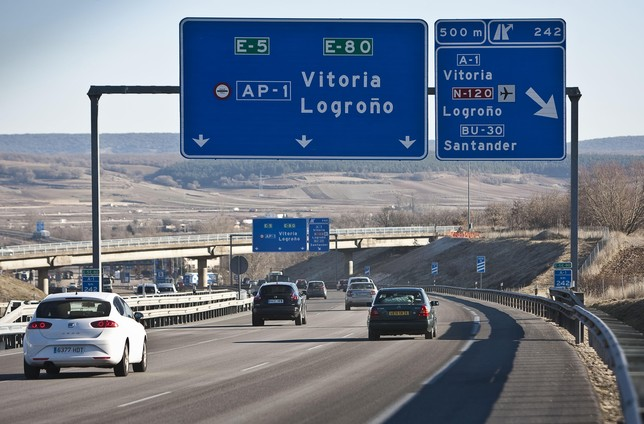

Observando la imagen adjunta podemos hacernos una idea sobre el tipo de información que nos permitirá distinguir un tipo de otro de panel, e incluso localizarlos en una imagen de carretera. En particular, se distinguen por su forma geométrica rectangular, por las zonas en las que se divide (borde claro y fondo oscuro) o por el color del mismo (azul y blanco). Es decir, para detectar este tipo de paneles podríamos utilizar:
- Un detector de regiones de alto contraste (detectaríamos la parte interna del panel).
- Un algoritmo que detectase rectángulos (p.ej., combinando detección de líneas con detectores de esquinas).
- Un algoritmo para descubrir qué píxeles son de color azul en la imagen junto con su distribución espacial.
- Detectar ciertas formas que aparecen en los paneles en localizaciones especiales (símbolo de salida de la autopista por la izquierda o derecha, diversos tipos de flechas, etc.).
- Cualquier otra técnica que tenga en cuenta color y forma.

El objetivo de esta práctica es desarrollar un detector básico de sub-paneles de información en autovías (como se ve en la figura adjunta). Hablamos de sub-paneles porque la idea es detectar cada una de las regiones rectangulares azules enmarcadas con un borde blanco en los paneles de la carretera. Para desarrollar el algoritmo de detección, como en muchos otros problemas de este tipo, se ofrece una
colección de imágenes de test tomadas desde un coche.

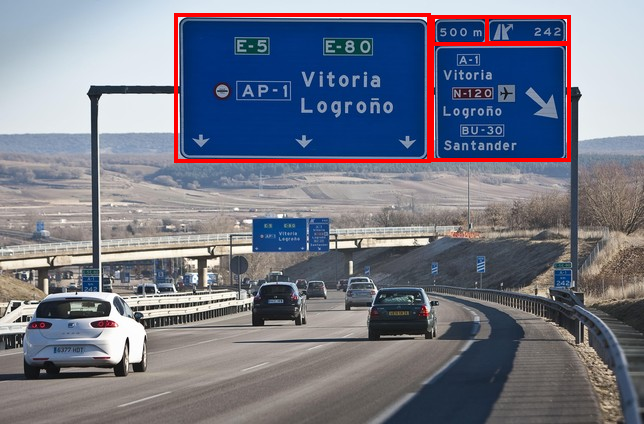

In [37]:
# Importacion de librerias 
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt, colors
from colorsys import hsv_to_rgb
from random import random

# Carga de imagenes
Cargar las imágenes de aprendizaje en color, guardarlas en una lista y mostrar la primera y la última usando imshow de matplotlib.

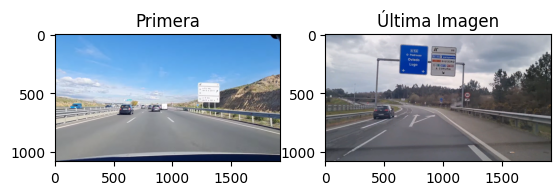

In [38]:
# Funcion para cargar todas las imagenes y guardarlas en una lista 
def cargarImagenes(carpetaImagenes):
    imagenes = []
    for archivo in os.listdir(carpetaImagenes):
        if archivo.endswith(".jpg") or archivo.endswith(".png"):
            rutaImagen = os.path.join(carpetaImagenes, archivo)
            imagen = cv2.imread(rutaImagen)
            if imagen is not None:
                imagenes.append(imagen)
    return imagenes

def mostrarPrimeraYUltima(imagenes):
    # Mostrar la primera y la ultima imagen 
    if len(imagenes) > 0:
        # Crear la figura y los ejes
        _, axes = plt.subplots(1, 2)

        axes[0].imshow(cv2.cvtColor(imagenes[0], cv2.COLOR_BGR2RGB))
        axes[0].set_title('Primera')

        axes[1].imshow(cv2.cvtColor(imagenes[-1], cv2.COLOR_BGR2RGB))
        axes[1].set_title('Última Imagen')

        plt.show()
    else:
        print("No se encontraron imágenes en la carpeta especificada.")

#-------------------------------------------------------------------------------------------------------------
# Cargar las imagenes y guardarlas en una lista 
listaImagenes = cargarImagenes('imagenesTest')

# Mostramos la primera y la ultima imagen de la lista
mostrarPrimeraYUltima(listaImagenes)

# Pasar a niveles de gris
Pasar las imágenes cargadas a niveles de gris (y, posiblemente, mejorar su contraste con las técnicas vistas en clase). Mostrar la primera y la última usando imshow de matplotlib.

In [39]:
def pasarAGris(imagen): 
    iGris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Para aumetar el nivel de contraste en las imagenes equalizamos el histograma
    equ_image = cv2.equalizeHist(iGris)

    return equ_image

# Filtro de color azul
Primero vamos a aplicar un filtro de color a las imagenes para hallar las regiones del color azul de los carteles 

In [40]:
######################################################################################################################
# FILTRO QUE MEJOR FUNCIONA (Mejor que el anterior)
######################################################################################################################
def apply_blue_filter_niebla(images):
    filtered_images = []
    for image in images:
        # Corrección de contraste para reducir el efecto de la niebla
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(lab)
        lab_planes = list(lab_planes)  # Convertir a lista para modificar
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

        # Convertir a espacio de color HSV
        img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Crear máscara para zonas azules
        mask = cv2.inRange(img, np.array([90, 155, 0]), np.array([130, 255, 255]))

        filtered_images.append(mask)

    return filtered_images

# Ejemplo de uso
filtered_images = apply_blue_filter_niebla(listaImagenes.copy())


# Detección de regiones de alto contraste

Utilizar MSER como detector de regiones de alto contraste (mser.detectRegions). 

Crear una función que aplique MSER a la lista de imágenes. Hay que tener en cuenta que los parámetros de MSER se pueden ajustar en el constructor de la clase (cv2.MSER_create). El ajustar los parámetros puede suponer eliminar muchas detecciones incorrectas (http://stackoverflow.com/questionshttps://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python/17647500/exact-meaning-of-the-parameters-given-to-initialize-mser-in-opencv-2-4-x).

Mostrar el resultado de aplicar la función sobre la primera y la última imagen de la lista usando imshow de matplotlib.

### Aumentar saturacion de la imagen
Funcion para aumentar la saturacion de los colores y hacer que detecte mejor el color azul en caso de que antes no lo hiciera 

In [41]:
def increase_saturation_all(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Aumentar la saturación de toda la imagen
    hsv[:,:,1] = np.clip(hsv[:,:,1] * 3, 0, 255)

    # Convertir la imagen de vuelta a BGR
    result = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return result

In [42]:
def mser_rec(img): 
    # Dilatamos la imagen para hacer los bordes mas gruesos
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    filtered_image = cv2.dilate(img, kernel)
    filtered_image = filtered_image-img

    mser = cv2.MSER_create(delta=10, max_variation=0.05, min_area=700, max_area=5000)
    polygons, _ = mser.detectRegions(filtered_image)

    # Creamos una mascara para almacenar las regiones detectadas 
    mask = np.zeros((filtered_image.shape[0], img.shape[1]), dtype=np.uint8)

    hulls = []
    for p in polygons:
        hull = cv2.convexHull(p.reshape(-1, 1, 2))
        hulls.append(hull)
    
    return mask, polygons, hulls

In [45]:
def mser(original_images, list_images):
    list_images_regions = [] # Lista de imagenes con las regiones dibujadas
    list_of_masks = [] # Lista de listas de regiones detectadas en cada imagen 
    list_of_regions = [] # Lista de regiones de una imagen

    for i, img in enumerate(list_images):  
        copy_originald_img = original_images[i].copy()
        copy_filtered_img = list_images[i].copy()
        copy_original = original_images[i].copy()

        # Dilatamos la imagen para hacer los bordes mas gruesos
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
        filtered_image = cv2.dilate(copy_filtered_img, kernel)
        filtered_image = filtered_image-copy_filtered_img

        mser = cv2.MSER_create(delta=10, max_variation=0.05, min_area=700, max_area=5000)
        polygons, _ = mser.detectRegions(filtered_image)

        # Creamos una mascara para almacenar las regiones detectadas 
        mask = np.zeros((filtered_image.shape[0], img.shape[1]), dtype=np.uint8)

        hulls = []
        for p in polygons:
            hull = cv2.convexHull(p.reshape(-1, 1, 2))
            hulls.append(hull)

        if(len(hulls)==0):
            # Mostramos la primera y la ultima imagen 
            mask_rec, polygons_rec, hulls = mser_rec(apply_blue_filter_niebla([increase_saturation_all(copy_originald_img)])[0])
            list_of_regions.append(polygons_rec)
            list_of_masks.append(mask_rec)
        else:
            list_of_regions.append(polygons)
            list_of_masks.append(mask)
        
        # Dibujamos las regiones
        cv2.polylines(copy_original, hulls, 1, (0, 255, 0), 2)
        list_images_regions.append(copy_original)

    # Mostramos la primera y la ultima imagen 
    cv2.imshow('Detected Traffic Signs', list_images_regions[0])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imshow('Detected Traffic Signs', list_images_regions[-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return list_images_regions, list_of_masks, list_of_regions

#---------------------------------------------------------------------------------------------
# Llamamos a la funcion
list_image_regions, masks_list, regions_list = mser(listaImagenes, filtered_images)

Crear una función que extraiga en un rectángulo los píxeles de la región detectada (cv2.boundingRect).

Mostrar gráficamente el resultado de aplicar la función sobre la primera y la última imágenes devueltas en el paso anterior.

In [52]:
def rectangle_of_regions(original_images, list_masks, list_regions):
    list_images_rectangles = [] # Lista de imagenes con las regiones dentro de un rectangulo
    act_image = 0
    for image in original_images:
        copy = original_images[act_image].copy()
        for region in list_regions[act_image]:
            x, y, w, h = cv2.boundingRect(region)
            cv2.rectangle(list_masks[act_image], (x, y), (x + w, y + h), (255), -1)
            cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
        list_images_rectangles.append(copy)
        act_image = act_image + 1

    # Mostramos la primera y la ultima imagen 
    cv2.imshow('Detected Traffic Signs', list_images_rectangles[0])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imshow('Detected Traffic Signs', list_images_rectangles[-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return list_images_rectangles

#---------------------------------------------------------------------------------------------
# Llamamos a la funcion 
list_rectangles = rectangle_of_regions(listaImagenes, masks_list, regions_list)

In [53]:
# Para mostrar el resultado de otras imagenes 
for i,image in enumerate(list_rectangles):
    cv2.imshow('IMAGEN: '+ str(i), list_rectangles[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Crear una función que elimine las regiones con una relación de aspecto (ancho/alto) muy diferente de la que tienen los sub-paneles. Si las regiones son demasiado alargadas en horizontal o vertical se podrán eliminar.

Mostrar gráficamente el resultado de aplicar la función sobre alguna imagen que rechace y sobre otra que acepte.

In [47]:
def rectangle_filtered(original_images2, list_masks, list_regions):
    list_filtered_rectangles = [] # Lista de imagenes con los rectangulos que cumplen el tamanyo
    list_filtered_regions = [] # Lista de regiones filtradas 

    for i, image in enumerate(original_images2):
        filtered_regions_act_img = []

        copy = original_images2[i].copy() # Copia de la imagen actual

        for region in list_regions[i]:
            x, y, w, h = cv2.boundingRect(region)
            aspect_ratio = w / float(h)
            
            # Filtramos las regiones en funcion de la relacion de aspecto 
            if aspect_ratio > 0.6 and aspect_ratio < 6.5:
                filtered_regions_act_img.append(region)
                cv2.rectangle(list_masks[i], (x, y), (x + w, y + h), (255), -1)
                cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 2)

        list_filtered_regions.append(filtered_regions_act_img)
        list_filtered_rectangles.append(copy)

    # Mostramos la primera y la ultima imagen 
    cv2.imshow('Detected Traffic Signs', list_filtered_rectangles[0])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imshow('Detected Traffic Signs', list_filtered_rectangles[-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return list_filtered_rectangles, list_filtered_regions

#---------------------------------------------------------------------------------------------
# Llamamos a la funcion
list_filtered_rectangles, list_filtered_regions = rectangle_filtered(listaImagenes, masks_list, regions_list)

cv2.destroyAllWindows()

In [13]:
# Para mostrar el resultado de otras imagenes 
for i,image in enumerate(list_filtered_rectangles):
    cv2.imshow('IMAGEN: '+ str(i), list_filtered_rectangles[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

En los sub-paneles, es posible que MSER haya detectado originalmente la región azul interna al borde blanco. Por tanto, es conveniente agrandar un poco el rectángulo detectado para que la imagen recortada contenga el sub-panel completo (incluyendo el borde blanco, y no sólo su parte interna). Si no se hace esto podemos tener una tasa de detección peor de la que realmente tenemos dado que las detecciones no solaparán completamente con las anotaciones.

Crear una función que agrande la zona y que muestre gráficamente el resultado de aplicar la función sobre la primera y la última imágenes devueltas en la celda de la función en MSER.

In [49]:
def ampliar_regiones(list_images, list_filtered_regions):
    images_expand_regions = []
    regiones_ampliadas = []
    for i, img in enumerate(list_images):
        copy = img.copy()
        regiones_ampliadas_imagen = []
        for region in list_filtered_regions[i]:
            x, y, w, h = cv2.boundingRect(region)

            # Ajustar los límites del rectángulo para que no excedan los límites de la imagen
            x_new = max(0, x - 10)  
            y_new = max(0, y - 10)  
            w_new = min(img.shape[1] - x_new, w + 20)  
            h_new = min(img.shape[0] - y_new, h + 20)  
            tuple_of_coords = (x_new, y_new, w_new, h_new)

            rectangulo = cv2.rectangle(copy, (x_new, y_new), (x_new + w_new, y_new + h_new), (0, 0, 255), 2)
            regiones_ampliadas_imagen.append(rectangulo)
            pixels_region = list_images[i][y_new:y_new+h_new, x_new:x_new+w_new]
        images_expand_regions.append(copy)
        regiones_ampliadas.append(regiones_ampliadas_imagen)
    return images_expand_regions, regiones_ampliadas

#--------------------------------------------------------------------------------------------------------------------------
expand_regions, regiones_ampliadas = ampliar_regiones(listaImagenes.copy(), list_filtered_regions)

In [51]:
# Para mostrar el resultado de otras imagenes 
for i,image in enumerate(expand_regions):
    cv2.imshow('IMAGEN: '+ str(i), expand_regions[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [43]:
def eliminar_rectangulos_contenidos(list_images, regiones_ampliadas):
    

## Detección mediante correlación de máscaras

En esta sección se desea utilizar el espacio de color HSV para localizar los píxeles que sean del color azul (característico del panel) y que estén muy saturados (tiene que ser un azul bastante puro). 

Para ello, en primer lugar se necesita construir una máscara ideal. Por ejemplo un np.array de tamaño fijo (p.ej. 40x80) en el que los píxeles azules y muy saturados tengan valor 1, y 0 el resto. Esta matriz será la máscara de color azul saturado del sub-panel informativo general. La máscara indicaría en qué píxeles debería tener color azul saturado el subpanel.

Mostrar gráficamente la máscara ideal usando imshow.

In [19]:
# On proyect

Crear una función que recorte cada ventana detectada por MSER en una imagen y devuelva una lista de imágenes con un tamaño fijo (p.ej. 40x80 píxeles) usando cv2.resize.


Mostrar gráficamente el resultado de aplicar dicha función sobre una imagen que tenga varios paneles.

Crear una función que extraiga los píxeles de color azul saturado (que llamaremos M) de la ventana redimensionada.

Mostrar gráficamente el resultado de aplicar dicha función sobre los paneles detectados en la celda anterior.

Crear una función que correle M (multiplicar elemento a elemento y sumar), con la máscara de color azul saturado ideal que debería tener un sub-panel de carretera (p.ej. casi todos los píxeles a 1). Se puede
usar el valor de correlación para saber cuál es la proporción de píxeles de color azul saturado en el sub-panel evaluado. 

Mostrar gráficamente el resultado de aplicar dicha función sobre los paneles detectados en la celda anterior y que muestre también el valor numérico de dicha correlación.

Si se pone un umbral también se pueden rechazar ventanas como “no panel” cuando tienen una correlación muy baja (es decir, las que “tienen poco azul”).

Si al correlar se supera el umbral, establecer el valor de correlación como la puntuación, o score, que daremos a esa ventana detectada. Ello nos indicará “cómo de parecido es lo detectado a un sub-panel” esa parte de la imagen (0 no es sub-panel y 1 sí lo es).

Establecer un umbral que permita rechazar algunas imágenes que realmente habría que rechazar y que acepte algunas imágenes que debería aceptar.

Mostrar gráficamente algunas imágenes, los valores de correlación obtenidos y el resultado de aplicar el umbral.

## Eliminación de detecciones repetidas

MSER detecta la parte interna del sub-panel (p.ej. la parte azul dentro del borde blanco) varias veces dependiendo de los parámetros que le pasemos y además la parte externa (el borde), con lo que muy probablemente tendremos más de una detección correspondiente a cada sub-panel. En esta parte de la práctica se pide diseñar un algoritmo para la que las ventanas repetidas se queden reducidas a una sola detección. Este algoritmo puede utilizar alguna de las siguientes ideas:
- Definir un criterio de solapamiento de ventanas (p.ej. el área de la intersección dividido por el área de la unión de dos ventanas).
- Elegir la ventana que contenga a otras de las que se solapen.
- Elegir la ventana promedio de las que solapen.
- Otros criterios propuestos por los alumnos.

Crear una función filtre los resultados de MSER y mostrar los resultados de aplicar dicha función sobre algunos ejemplos donde tenga impacto.

## Evaluación de los resultados de detección

Seleccionar un subconjunto de, al menos, 20 imágenes del conjunto de imágenes de test proporcionado. Estas imágenes deben de ser lo suficientemente representativas como para contener todas las variabilidades presentes en el dataset de imágenes (p.ej., diferentes condiciones meteorológicas, diferentes tamaños y perspectivas de los sub-paneles en las escenas, etc). 

Mostrar gráficamente dichas imágenes en una matriz de tamaño suficiente usando la función subplot de matplotlib.

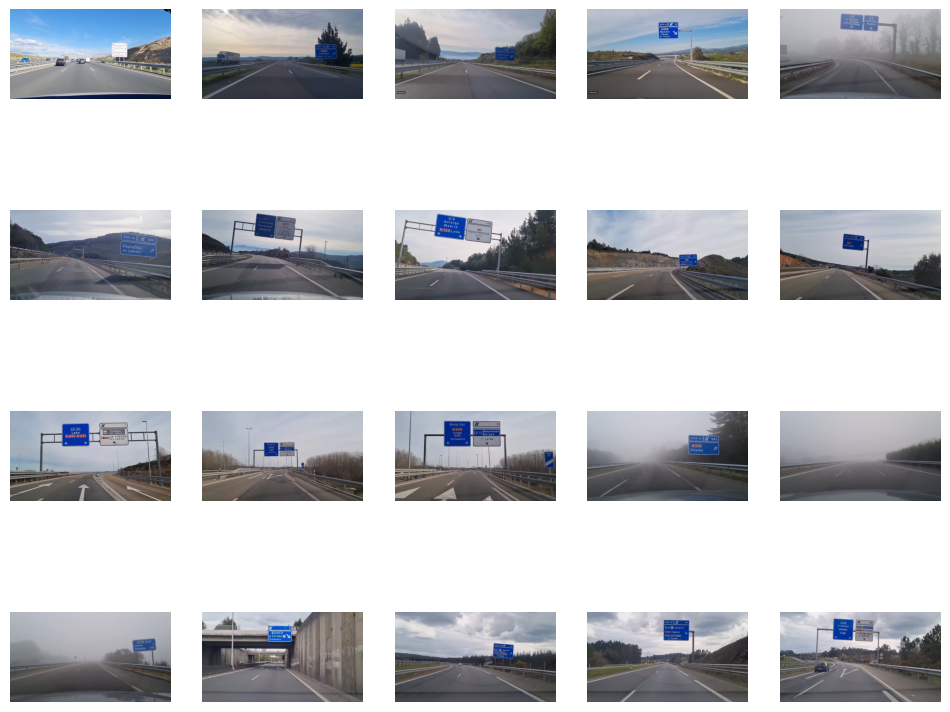

In [20]:
def show_20_images(imagenes):
    # Crear la figura y los ejes
    fig, axs = plt.subplots(4, 5, figsize=(12, 10))

    # Mostrar cada imagen en su respectivo subplot
    for i, ax in enumerate(axs.flat):
        ax.imshow(cv2.cvtColor(imagenes[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')

    plt.show()

imgs = []
indices_imagenes = [0, 4, 10, 16, 20, 38, 45, 49, 54, 57, 64, 69, 70, 74, 81, 83, 93, 99, 100, 101]
for indice in indices_imagenes:
    imgs.append(listaImagenes[indice])

show_20_images(imgs)

Para las 20 imágenes de test seleccionadas, pintar (por ejemplo, en color rojo), los rectángulos donde se han detectado los sub-paneles en cada una de las imágenes consideradas.

Mostrar gráficamente dichas imágenes en una matriz de tamaño suficiente usando la función subplot de matplotlib.

Mostrar resultados cuantitativos de detección usando la métrica de IoU (Intersection over Union)

## Normalización de las imágenes de los paneles detectados

Muchos paneles detectados en las imágenes pueden aparecer ligeramente rotados (debido al efecto de la perspectiva) y/o también afectados por unas condiciones de iluminación desfavorable. Ello puede  dificultar el posterior reconocimiento de la información contenida en los mismos. La Figura adjunta ilustra un ejemplo de esta situación.

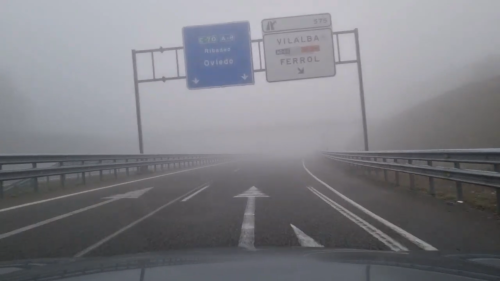

En este apartado se pide desarrollar una función que aplique las normalizaciones que se consideren con respecto a la posición del cartel en la imagen y/o la corrección del efecto de la iluminación.

Mostrar gráficamente el resultado de aplicar dicha normalización sobre un conjunto de imágenes que lo requieran.

In [21]:
img = cv2.imread('imagenesTest/0008.png', 0)
edges_img = cv2.Canny(img, 50, 150, apertureSize=3)

# Resolución de rho, theta y número de puntos mínimo para considerar recta
lines = cv2.HoughLines(edges_img, 1, np.pi/180, 200)
color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Define los límites para la longitud de la línea
min_length = 0
max_length = 10000

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    # Encuentra los puntos finales de la línea
    x1 = int(x0 + min_length * (-b))
    y1 = int(y0 + min_length * (a))
    x2 = int(x0 + max_length * (-b))
    y2 = int(y0 + max_length * (a))
    # Calcula la longitud de la línea
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if min_length < length < max_length:
        cv2.line(color, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.figure(figsize=(15, 15))
plt.imshow(color)
plt.show()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
